<hr style="height:2px;">

# Demo: Denoising of 2D cell images


This notebook demonstrates how to use [CARE](http://csbdeep.bioimagecomputing.com/) for a simple 2D denoising task, where corresponding pairs of low and high signal-to-noise ratio (SNR) images of cells are available. 
The high SNR images are acquistions of Human U2OS cells taken from the [Broad Bioimage Benchmark Collection](https://data.broadinstitute.org/bbbc/BBBC006/) and the low SNR images were created by synthetically adding strong Gaussian noise.  

![](imgs/img_intro.png)

Each image pair should be registered, which in a real application setting is best achieved by acquiring both stacks _interleaved_, i.e. as different channels that correspond to the different exposure/laser settings. 

Since the image pairs were synthetically created in this example, they are already aligned perfectly.

First, we will import some python modules...

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from tifffile import imread
from csbdeep.utils import download_and_extract_zip_file, plot_some
from csbdeep.data import RawData, create_patches

/sw/apps/python3/3.6.5/lib/python3.6/site-packages/tifffile/tifffile.py:7685: UserWarning: No module named 'tifffile._tifffile'
  Functionality might be degraded or be slow.

  warnings.warn('%s%s' % (e, warn))


<hr style="height:2px;">

# Example data

The example data consists of low-SNR and high-SNR 2D images of human U2OS cells.  
Note that `GT` stands for [ground truth](https://en.wikipedia.org/wiki/Ground_truth) and represents high signal-to-noise ratio (SNR) stacks.

In [2]:
%%bash
mkdir -p data
ln -s ~/fastfs/data/bbc006 data/bbc006
tree data/bbc006

data/bbc006
├── bbc006 -> /home/mweigert/data/bbc006
├── test
│   ├── GT
│   │   ├── img_0000.tif
│   │   ├── img_0001.tif
│   │   ├── img_0002.tif
│   │   ├── img_0003.tif
│   │   ├── img_0004.tif
│   │   ├── img_0005.tif
│   │   ├── img_0006.tif
│   │   ├── img_0007.tif
│   │   ├── img_0008.tif
│   │   ├── img_0009.tif
│   │   ├── img_0010.tif
│   │   ├── img_0011.tif
│   │   ├── img_0012.tif
│   │   ├── img_0013.tif
│   │   ├── img_0014.tif
│   │   ├── img_0015.tif
│   │   ├── img_0016.tif
│   │   ├── img_0017.tif
│   │   ├── img_0018.tif
│   │   ├── img_0019.tif
│   │   ├── img_0020.tif
│   │   ├── img_0021.tif
│   │   ├── img_0022.tif
│   │   ├── img_0023.tif
│   │   ├── img_0024.tif
│   │   ├── img_0025.tif
│   │   ├── img_0026.tif
│   │   ├── img_0027.tif
│   │   ├── img_0028.tif
│   │   ├── img_0029.tif
│   │   ├── img_0030.tif
│   │   ├── img_0031.tif
│   │   ├── img_0032.tif
│   │   ├── img_0033.tif
│   │   ├── img_0034.tif
│   │   ├── img_0035.tif
│   │   ├── img_0036.tif
│ 

We can plot some training images:

image size = (256, 256)


Text(0.5,1,'high')

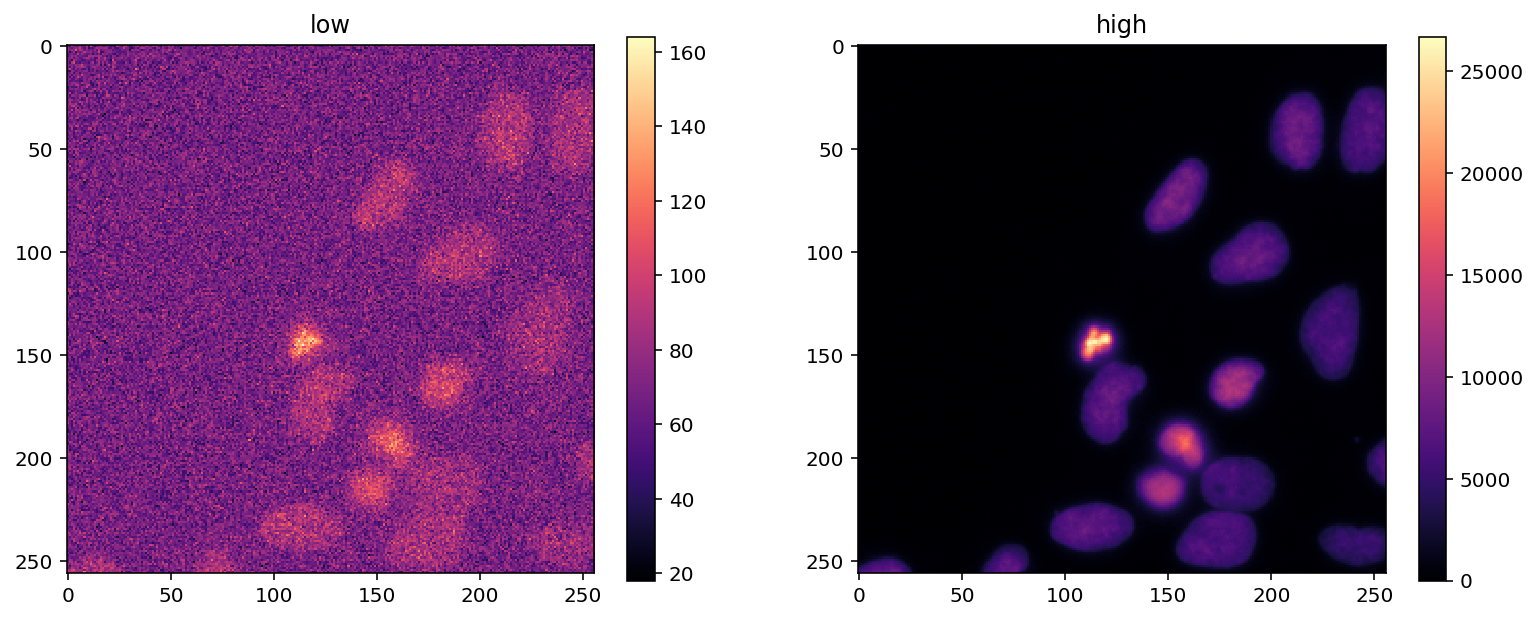

In [3]:
y = imread('data/bbc006/train/GT/img_0010.tif')
x = imread('data/bbc006/train/low/img_0010.tif')
print('image size =', x.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.imshow(x, cmap  ="magma")
plt.colorbar()
plt.title("low")
plt.subplot(1,2,2)
plt.imshow(y, cmap  ="magma")
plt.colorbar()
plt.title("high")

<hr style="height:2px;">

# Generate training data for CARE

We first need to create a `RawData` object, which defines how to get the pairs of low/high SNR stacks and the semantics of each axis (e.g. which one is considered a color channel, etc.).

Here we have two folders "low" and "GT", where corresponding low and high-SNR stacks are TIFF images with identical filenames.  
For this case, we can simply use `RawData.from_folder` and set `axes = 'YX'` to indicate the semantic order of the image axes (i.e. we have 2 dimensional images in standard xy layout). 

In [4]:
raw_data = RawData.from_folder (
    basepath    = 'data/bbc006/train',
    source_dirs = ['low'],
    target_dir  = 'GT',
    axes        = 'YX',
)

From corresponding stacks, the function `create_patches` will now generate lots of paired patches that will be used for training the CARE model later.

`create_patches` returns values `(X, Y, XY_axes)`.
By convention, the variable name `X` (or `x`) refers to an input variable for a machine learning model, whereas `Y` (or `y`) indicates an output variable.


As a general rule, use a *patch size* that is a power of two along all axis, or at least divisible by 8. For this example we will use patches of size (128x128).

An important aspect is *data normalization*, i.e. the rescaling of corresponding patches to a dynamic range of ~ (0,1). By default, this is automatically provided via percentile normalization, which can be adapted if needed. 

By default, patches are sampled from *non-background regions* i.e. that are above a relative threshold that can be given in the function below. We will disable this for the current example as most images region already contain foreground pixels and thus set the threshold to 0.  

In [5]:
from csbdeep.data import no_background_patches, norm_percentiles, sample_percentiles

X, Y, XY_axes = create_patches (
    raw_data            = raw_data,
    patch_size          = (128,128),
    patch_filter        = no_background_patches(0),
    n_patches_per_image = 2,
    save_file           = 'data/my_training_data.npz',
)

 1000 raw images x    1 transformations   =  1000 images
 1000 images     x    2 patches per image =  2000 patches in total
Input data:
data/bbc006/train: target='GT', sources=['low'], axes='YX', pattern='*.tif*'
Transformations:
1 x Identity
Patch size:
128 x 128


100%|██████████| 1000/1000 [00:12<00:00, 77.88it/s]


Saving data to data/my_training_data.npz.


In [6]:
assert X.shape == Y.shape
print("shape of X,Y =", X.shape)
print("axes  of X,Y =", XY_axes)

shape of X,Y = (2000, 1, 128, 128)
axes  of X,Y = SCYX


## Show some example patches

This shows the some of the generated patch pairs (even rows: *input*, odd rows: *target*)

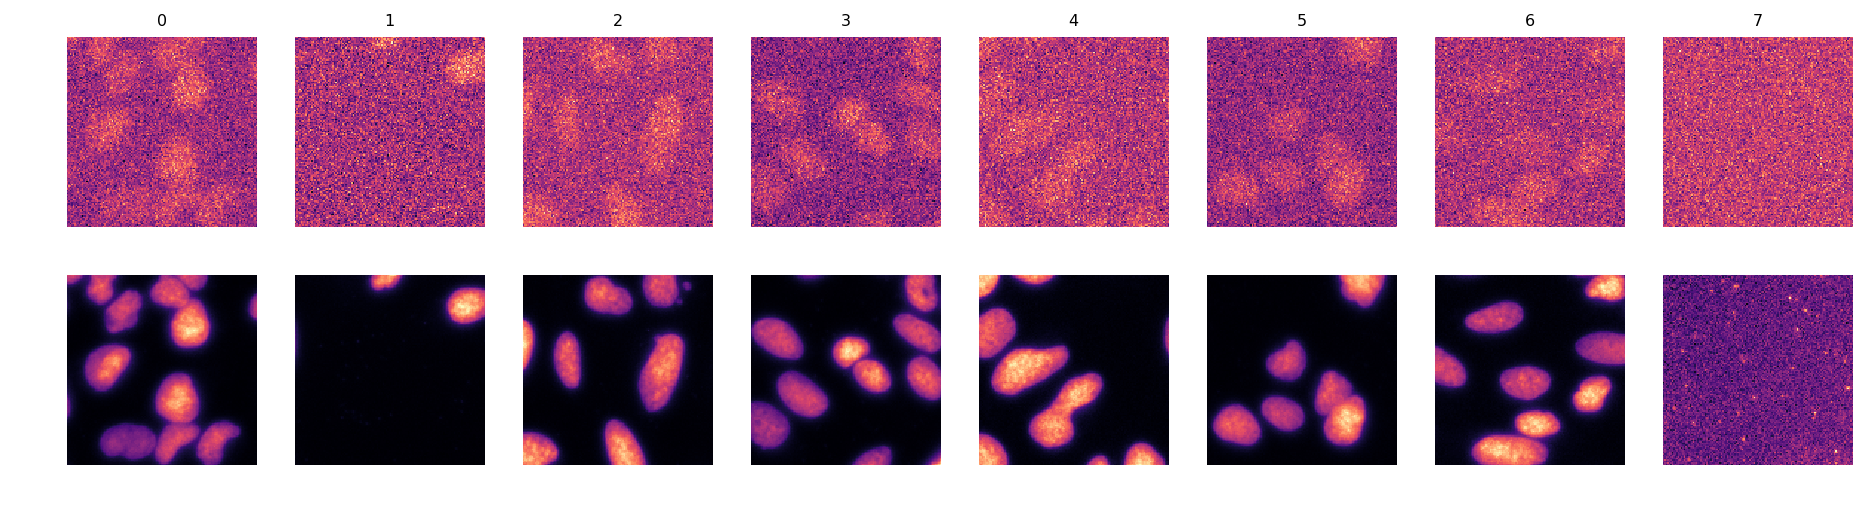

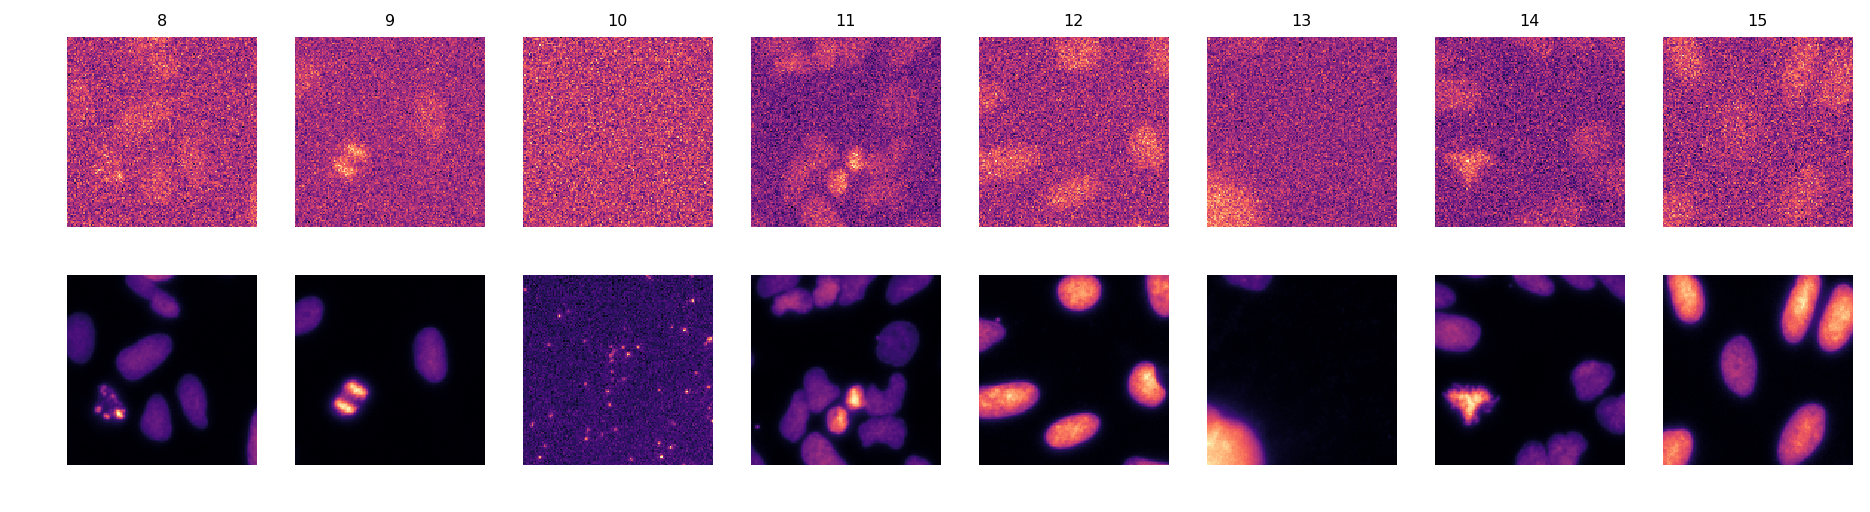

In [7]:
for i in range(2):
    plt.figure(figsize=(16,4))
    sl = slice(8*i, 8*(i+1)), 0
    plot_some(X[sl],Y[sl],title_list=[np.arange(sl[0].start,sl[0].stop)])
    plt.show()
None;